In [1]:
import ee
import geemap
import pandas as pd
import altair as alt
import numpy as np
import folium
import matplotlib.pyplot as plt

In [2]:
ee.Authenticate()
ee.Initialize()


In [3]:
# Enhanced soil moisture datasets.
smap = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture')

# Precipitation datasets.
prep = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V06')


In [4]:
# Get the first image in the collection
first_image = smap.first()

# Get the band names of the first image
band_names = first_image.bandNames()

# Print the band names
print("Band Names:", band_names.getInfo())


Band Names: ['ssm', 'susm', 'smp', 'ssma', 'susma']


In [5]:
# Get the first image in the collection
first_image = prep.first()

# Get the band names of the first image
band_names = first_image.bandNames()

# Print the band names
print("Band Names:", band_names.getInfo())


Band Names: ['gaugeRelativeWeighting', 'precipitation', 'precipitationQualityIndex', 'probabilityLiquidPrecipitation', 'randomError']


In [6]:
#import shapefile
project_area = ee.FeatureCollection("projects/connect-gaea/assets/project_areas")
aoi = project_area.geometry()

In [7]:
Map = geemap.Map()
Map.addLayer(aoi, {}, 'Area of interest')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [8]:
# Filter the SMAP ImageCollection by the AOI
smap_within_aoi = smap.filterBounds(aoi)

# Get the first image in the filtered collection
first_image_within_aoi = smap_within_aoi.first()

# Get the band names of the first image
band_names_within_aoi = first_image_within_aoi.bandNames()

# Print the band names
print("Band Names within AOI:", band_names_within_aoi.getInfo())


Band Names within AOI: ['ssm', 'susm', 'smp', 'ssma', 'susma']


In [9]:
# Define study period.
startYear = 2016
endYear = 2024
startMonth = 1
endMonth = 12

startDate = ee.Date.fromYMD(startYear, startMonth, 1)
endDate = ee.Date.fromYMD(endYear, endMonth, 31)
years = ee.List.sequence(startYear, endYear)
months = ee.List.sequence(1, 12)


In [10]:
# Define a function to convert GPM IMERG from mm/hr to mm/day.
def gpmScale(image):
  return image.multiply(24) \
              .copyProperties(image, ['system:time_start'])

In [11]:
# Define a function to compute the anomaly for a given month.
def computeAnomalyPrecipitation(image):
  # Get the month of the image.
  year = image.date().get('year')
  month = image.date().get('month')
  # Get the corresponding reference image for the month.
  referenceImage = meanMonthlyPrecipitation.filter(
      ee.Filter.eq('month', month)).first()
  # Check if the images have bands
  hasBands = image.bandNames().size().gt(0)
  # Compute the anomaly by subtracting reference image from input image.
  anomalyImage = ee.Algorithms.If(
    hasBands,
    image.subtract(referenceImage),
    image)

  return ee.Image(anomalyImage).set(
    'system:time_start', ee.Date.fromYMD(year, month, 1).millis())

In [12]:
# Anomalies surface and subsurface soil moisture (mm).
ssSusMa = smap.filterDate(startDate, endDate).sort('system:time_start', True).select(['ssma', 'susma'])  


In [13]:
# Get the first image in the collection
first_image = ssSusMa.first()

# Get the band names of the first image
band_names = first_image.bandNames()

# Print the band names
print("Band Names:", band_names.getInfo())

Band Names: ['ssma', 'susma']


In [14]:
# Compute monthly anomalies surface and subsurface soil moisture.
def map_over_years(y):
    def map_over_months(m):
        filtered = ssSusMa.filter(ee.Filter.calendarRange(y, y, 'year')) \
            .filter(ee.Filter.calendarRange(m, m, 'month')) \
            .mean()
        return filtered.set('system:time_start', ee.Date.fromYMD(y, m, 1).millis())
    return months.map(map_over_months)

monthlySsSusMa = ee.ImageCollection.fromImages(years.map(map_over_years).flatten())


In [15]:
# Precipitation from monthly GPM IMERG Final product (mm/day).
rawMonthlyPrecipitation = prep \
.select('precipitation')\
.filterDate(startDate, endDate)\
.sort('system:time_start', True)\
.map(gpmScale)

In [16]:
# Make sure monthly precipitation has same duration as soil moisture.
def map_over_years(y):
    def map_over_months(m):
        filtered = rawMonthlyPrecipitation \
            .filter(ee.Filter.calendarRange(y, y, 'year')) \
            .filter(ee.Filter.calendarRange(m, m, 'month')) \
            .mean()
        return filtered.set({
            'month': m,
            'system:time_start': ee.Date.fromYMD(y, m, 1).millis()
        })
    return months.map(map_over_months)

monthlyPrecipitation = ee.ImageCollection.fromImages(years.map(map_over_years).flatten())

In [17]:
# Compute climatological monthly precipitation.
def map_over_months(m):
    filtered = monthlyPrecipitation.filter(ee.Filter.eq('month', m)).mean()
    return filtered.set('month', m)

meanMonthlyPrecipitation = ee.ImageCollection.fromImages(
    ee.List.sequence(1, 12).map(map_over_months)
)

In [18]:
# Map the function over the monthly precipitation collection to compute
# the anomaly precipitation for each month.
monthlyPrecipitationAnomalies = monthlyPrecipitation.map(computeAnomalyPrecipitation)

In [19]:
# Combine two image collections into one collection.
smpreDatasets = monthlySsSusMa.combine(monthlyPrecipitationAnomalies)


In [21]:
# Filter the SMAP ImageCollection by the AOI
smap_within_aoi = smpreDatasets.filterBounds(aoi)

# Get the first image in the filtered collection
first_image_within_aoi = smap_within_aoi.first()

# Get the band names of the first image
band_names_within_aoi = first_image_within_aoi.bandNames()

# Print the band names
print("Band Names within AOI:", band_names_within_aoi.getInfo())

Band Names within AOI: ['ssma', 'susma', 'precipitation']


In [22]:
import matplotlib.pyplot as plt

In [25]:
def get_data(image_collection, band_name):
    def calc_mean(img):
        mean = ee.Algorithms.If(
            img.bandNames().contains(band_name),
            img.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=10000).get(band_name),
            None
        )
        return img.set('date', img.date().format()).set('mean', mean)
    data_list = image_collection.map(calc_mean).filter(ee.Filter.notNull(['mean'])).reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).get('list')
    data = pd.DataFrame(data_list.getInfo(), columns=['date', band_name])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    return data


In [26]:
# Get data from the ImageCollections.
ssma_data = get_data(smpreDatasets, 'ssma')
susma_data = get_data(smpreDatasets, 'susma')
precipitation_data = get_data(smpreDatasets, 'precipitation')

In [30]:
# Sort the DataFrames by date.
ssma_data = ssma_data.sort_index()
susma_data = susma_data.sort_index()
precipitation_data = precipitation_data.sort_index()


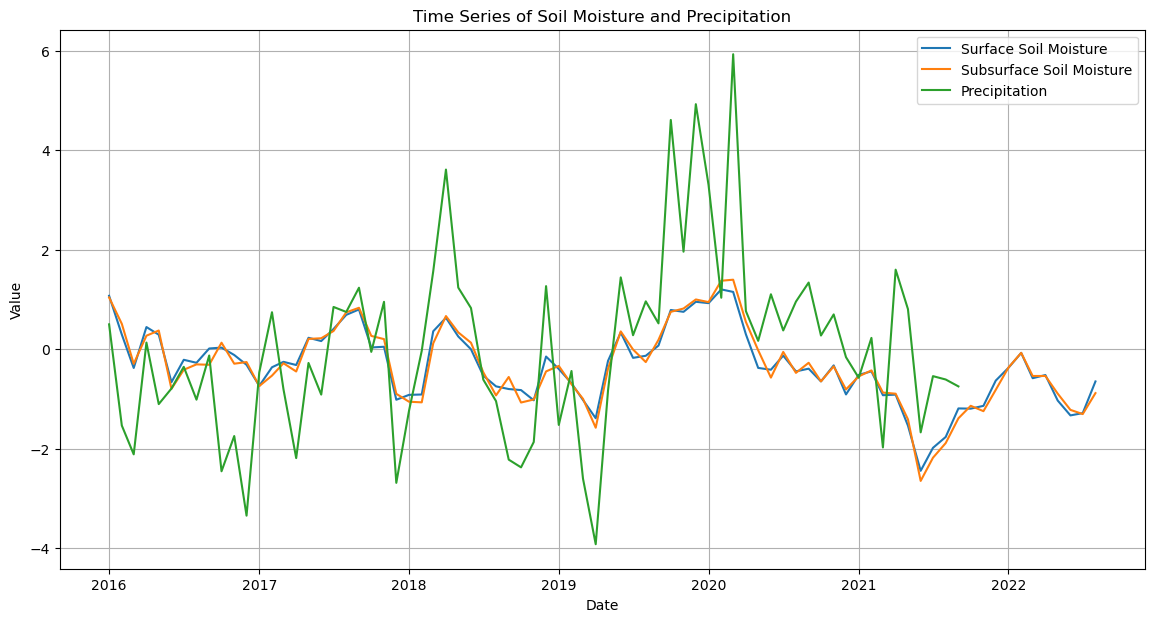

In [31]:
# Plot the data.
plt.figure(figsize=(14, 7))
plt.plot(ssma_data.index, ssma_data['ssma'], label='Surface Soil Moisture')
plt.plot(susma_data.index, susma_data['susma'], label='Subsurface Soil Moisture')
plt.plot(precipitation_data.index, precipitation_data['precipitation'], label='Precipitation')
plt.title('Time Series of Soil Moisture and Precipitation')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Export the ssma_data DataFrame to a CSV file.
ssma_data.to_csv('ssma_data.csv')

# Export the susma_data DataFrame to a CSV file.
susma_data.to_csv('susma_data.csv')

# Export the precipitation_data DataFrame to a CSV file.
precipitation_data.to_csv('precipitation_data.csv')
